# Predicting Areas of Affluence using Yelp Pricing Data

#### Authors: 
- Eddie Yip [LinkedIn](https://www.linkedin.com/in/eddie-yip-2a37324b/) | [Medium](https://medium.com/@eddie.yip2)
- Hadi Morrow [LinkedIn](https://www.linkedin.com/in/hadi-morrow-4b94164b/) | [GitHub](https://github.com/HadiMorrow) | [Medium](https://medium.com/@hadi.a.morrow)
- Mahdi Shadkam-Farrokhi: [GitHub](https://github.com/Shaddyjr) | [Medium](https://medium.com/@mahdis.pw) | [http://mahdis.pw](http://mahdis.pw)

## Problem Statement [Hadi]

While affluence should never be a factor when choosing to provide disaster aid or not, we must consider the following:

- On the assumption that affluence plays a role, one might relate affluency to preparedness. Those who can afford to will always look out for their families at any cost. Those who can not might not be able to prepare as well due to the fact that it is not an option. 

- On the assumption that affluence is not part of a majority class, if we should be miopic with our search efforts we might want to consider saving the masses, those living in tight coridors and those with little to no income. If effect those most suseptible to losing their lives in a major disaster. 

- Using tax data we aim to show that using YELP data dollar signs is enough to predict where we might want to quickly and accuratly align our efforts. 

New Light Technologies as our audience, we hope to show that while using expensive and hard to handle data such as tax data can be more precise, a quick and dirty aproach could be to simply sord though the dollar signs data on yelp. 

---
[Hadi] - Excellent write up! Here are some of my observations - feel free to include or not, totally up to you.
1. It would be nice for the reader if we define 'affluence' here at the start. What do we consider "affluent" in our data (I think we mentioned 15% of the area code?)?
2. As a reader, it would be VERY compelling to have an actual case where a natural disaster occured and the affluent areas weren't affected. If possible, research 1 or 2 cases when affluent areas were better prepared for natural disasters - this will help prove our predictive model has a real use case.
3. Tying into the use case, it might be helpful to mention a realistic disaster scenario when only having Yelp! price data would be useful. Like, there's an emergency and there's little time to pull granular information about the area, but knowing the yelp reviews for an area, allows first-responders to know which areas their efforts will have the most impact

## Executive Summary [Mahdi]

- Difficulty gathering data
- Prompt confusing regarding "affluence"
- Other projects used outside data as metric
- We pulled from API and didn't use old data, which was challenging

## Table of Contents
- [Gathering Data](#Gathering-Data)
- [Loading Data](#Loading-Data)
- [Preliminary Exploratory Data Analysis](#Preliminary-Exploratory-Data-Analysis)
- [Cleaning the Data](#Cleaning-the-Data)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Preparation](#Model-Preparation)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Source Documentation](#Source-Documentation)

## Gathering Data
We got Yelp data using the API - link 
 
We got IRS data using - source [Eddie]

## Loading Data
- [All]

In [137]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import columnExpander
from ast import literal_eval
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [138]:
data_file_path = "./data/total_merged.csv"
df_yelp = pd.read_csv(data_file_path, index_col = 0)
df_yelp.reset_index(drop=True, inplace = True) # same indeces were merged using multiple API calls

In [139]:
df_yelp.shape

(11225, 16)

## Preliminary Exploratory Data Analysis
- [All]

In [140]:
df_yelp.head()

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,mos-original-brooklyn,"[{'alias': 'ramen', 'title': 'Ramen'}, {'alias...","{'latitude': 40.66127, 'longitude': -73.95342}",(718) 513-0698,1542.617156,YwpP-mgXV5N35xhLibLw5g,https://s3-media2.fl.yelpcdn.com/bphoto/-L9roT...,False,"{'address1': '453 Rogers Ave', 'address2': Non...",Mo's Original,1.718513e+10,NaN,4.5,32,[],https://www.yelp.com/biz/mos-original-brooklyn...
1,peaches-hothouse-brooklyn,"[{'alias': 'southern', 'title': 'Southern'}, {...","{'latitude': 40.6833699737169, 'longitude': -7...",(718) 483-9111,3471.525420,GA5msU6NO9rQRctPfDJCBg,https://s3-media1.fl.yelpcdn.com/bphoto/KEAXgZ...,False,"{'address1': '415 Tompkins Ave', 'address2': '...",Peaches HotHouse,1.718484e+10,$$,4.0,1082,"['pickup', 'delivery']",https://www.yelp.com/biz/peaches-hothouse-broo...
2,claw-daddys-brooklyn,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...","{'latitude': 40.68561, 'longitude': -73.98035}",(347) 318-8893,5062.337404,1x2hn3e9sCCZca1cnRTpEg,https://s3-media3.fl.yelpcdn.com/bphoto/ABHo2x...,False,"{'address1': '31 3rd Ave', 'address2': '', 'ad...",Claw Daddy's,1.347319e+10,$$,4.0,282,['restaurant_reservation'],https://www.yelp.com/biz/claw-daddys-brooklyn?...
3,barons-brooklyn,"[{'alias': 'newamerican', 'title': 'American (...","{'latitude': 40.6908116, 'longitude': -73.953915}",(718) 230-7100,4451.492133,GxMhN2PEttvw7CRGIzB6Gg,https://s3-media3.fl.yelpcdn.com/bphoto/VmnsId...,False,"{'address1': '564 Dekalb Ave', 'address2': '',...",Baron's,1.718231e+10,$$,4.5,258,"['pickup', 'restaurant_reservation']",https://www.yelp.com/biz/barons-brooklyn?adjus...
4,lowerline-brooklyn-2,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...","{'latitude': 40.67421, 'longitude': -73.96324}",(347) 533-7110,3158.955607,swKXaURwqdSrSTcpHsxdbA,https://s3-media4.fl.yelpcdn.com/bphoto/oJbAhL...,False,"{'address1': '794 Washington Ave', 'address2':...",Lowerline,1.347534e+10,$$,4.5,118,[],https://www.yelp.com/biz/lowerline-brooklyn-2?...


In [141]:
sum_null = df_yelp.isnull().sum()
sum_null[sum_null > 0]

display_phone     697
image_url         417
phone             697
price            2013
dtype: int64

We have many missing values in the data, however many of the columns are not meaningful for our problem and these columns can be safely dropped.

Also, `categories`, `location`, and `transactions` are compressed data columns and will need to be unpacked.

## Cleaning the Data
- [Mahdi] one person for consistency

### Yelp Price

In [142]:
df_yelp["price"].isnull().sum()

2013

We decided to drop null prices from analysis as this is the key indicator we're looking to predict with.

In [143]:
df_yelp.dropna(subset=["price"], inplace = True)

In [144]:
df_yelp.shape

(9212, 16)

### Converting Yelp Price to ordinal values

In [145]:
df_yelp['price'] = df_yelp['price'].map({'$': 1, '$$': 2, '$$$': 3, '$$$$':4})

In [146]:
df_yelp['price'].value_counts()

2    5117
1    3361
3     601
4     133
Name: price, dtype: int64

### Dropping unneccessary columns

In [147]:
keepers = ['categories','id', 'location', 'price', 'rating', 'review_count', 'transactions', 'coordinates']
df_yelp = df_yelp[keepers]

### Parsing location data

In [148]:
def get_keys_from_sting_dict(string, keys):
    if len(string) == 0:
        return None
    dic = literal_eval(string)
    out = {}
    for key in keys:
        out[key] = dic.get(key)
    return out

In [149]:
location = "location"
keys = ["zip_code", "city", 'state']
zips_and_cities = df_yelp[location].map(lambda string: get_keys_from_sting_dict(string, keys))

for key in keys:
    df_yelp[key] = [pair[key] for pair in zips_and_cities]
    
df_yelp.drop(columns=[location], inplace = True)

### Filtering for NYC-only

#### Removed non-NY state

In [150]:
df_yelp = df_yelp[df_yelp['state'] == "NY"]

#### Imputing missing zip codes

In [151]:
df_yelp[df_yelp['zip_code'] == ""]

,categories,id,price,rating,review_count,transactions,coordinates,zip_code,city,state
6940,"[{'alias': 'cupcakes', 'title': 'Cupcakes'}, {...",ECY0sIYxPJio81dteqiMhg,2,4.5,16,[],"{'latitude': 40.71455, 'longitude': -74.00714}",,New York,NY
8092,"[{'alias': 'bakeries', 'title': 'Bakeries'}]",6u5cnsN35mJz24HMQ9pfFw,2,2.0,15,[],"{'latitude': 40.605271, 'longitude': -74.149243}",,Staten Island,NY
10283,"[{'alias': 'foodstands', 'title': 'Food Stands'}]",BilbRcNQXKmcBFvLm4gxAQ,2,5.0,3,[],"{'latitude': 40.7488639529741, 'longitude': -7...",,Queens,NY
10401,"[{'alias': 'farmersmarket', 'title': 'Farmers ...",jZzbV6SRt9FXdCoziNv5xw,2,4.0,4,[],"{'latitude': 40.7454635299775, 'longitude': -7...",,Queens,NY


Locations were found using Google Maps and zip codes imputed manually

In [152]:
df_yelp.loc[df_yelp["id"] == "ECY0sIYxPJio81dteqiMhg","zip_code"] = "10007"
df_yelp.loc[df_yelp["id"] == "6u5cnsN35mJz24HMQ9pfFw","zip_code"] = "10314"
df_yelp.loc[df_yelp["id"] == "BilbRcNQXKmcBFvLm4gxAQ","zip_code"] = "11372"
df_yelp.loc[df_yelp["id"] == "jZzbV6SRt9FXdCoziNv5xw","zip_code"] = "11373"

### Remove by NYC zip
We used the range of zip codes designated for NYC - [source](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)

In [153]:
min_zip = 10001
max_zip = 11697

df_yelp['zip_code'] = df_yelp['zip_code'].astype(int)

In [154]:
df_yelp = df_yelp[(df_yelp['zip_code'] >= min_zip) & (df_yelp['zip_code'] <= max_zip)]

### Parsing Coordinates

In [155]:
coordinates = "coordinates"
coord_keys = ["latitude", "longitude"]
lat_and_long = df_yelp[coordinates].map(lambda string: get_keys_from_sting_dict(string, coord_keys))

for key in coord_keys:
    df_yelp[key] = [pair[key] for pair in lat_and_long]

df_yelp.drop(columns=[coordinates], inplace = True)

In [156]:
df_yelp[coord_keys].describe()

,latitude,longitude
count,8985.000000,8985.000000
mean,40.730034,-73.913326
std,0.076368,2.207460
min,40.508927,-74.251140
25%,40.683368,-73.988678
50%,40.740450,-73.960316
75%,40.765829,-73.890592
max,41.004690,74.000792


Looking at the latitude and longitude, we see some points that do not appear to be in the New York City area, around 40.7 and -73.9, respectively.

In [157]:
df_yelp[(df_yelp["latitude"] > 41) | (df_yelp["latitude"] < 40)]

,categories,id,price,rating,review_count,transactions,zip_code,city,state,latitude,longitude
3224,"[{'alias': 'tradamerican', 'title': 'American ...",_pe4POL8iJPohFqPvWehIg,2,4.0,857,[],10583,Scarsdale,NY,41.00469,-73.81312


This data point is from Scarsdale NY, which is not within the city limits. This data point will be dropped.

In [158]:
df_yelp = df_yelp[(df_yelp["latitude"] <= 41) & (df_yelp["latitude"] >= 40)]

In [159]:
df_yelp[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75)]

,categories,id,price,rating,review_count,transactions,zip_code,city,state,latitude,longitude
3306,"[{'alias': 'pizza', 'title': 'Pizza'}]",S2mqyVGw817y9GTHxYRPjw,1,4.0,58,[],10472,Bronx,NY,40.830034,73.850772
8560,"[{'alias': 'icecream', 'title': 'Ice Cream & F...",dF02U8Yhxnm66Np4Adgovg,2,4.0,290,[],10012,New York,NY,40.723884,74.000792


After looking up these businesses, it is clear they were given a positive longitude when they are actually supposed to be negative.

In [160]:
df_yelp.loc[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75),"longitude"] = np.negative(df_yelp[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75)]["longitude"])

### Parsing categories

In [161]:
def convert_string_dict_to_string(string, key):
    return ",".join([dic[key] for dic in literal_eval(string)])

df_yelp["categories"] = df_yelp["categories"].map(lambda s: convert_string_dict_to_string(s,"alias"))

### Parsing transactions

In [162]:
def convert_string_list_to_string(string):
    return ",".join(literal_eval(string))

df_yelp["transactions"] = df_yelp["transactions"].map(convert_string_list_to_string)

In [163]:
df_yelp.shape

(8984, 11)

In [164]:
df_yelp.isnull().sum().sum()

0

There are no null values - this is a complete dataset

### Cleaning IRS Dataset [Hadi]
These data were collected directly from the IRS website ([source](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi))

In [165]:
df_irs = pd.read_csv('./data/irs.csv')

In [166]:
df_irs[10:20]

,ZIP code [1],Size of adjusted gross income,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents
10,10001,"$25,000 under $50,000",2500,1850,240,340,1360,3390,690
11,10001,"$50,000 under $75,000",1950,1540,190,160,1110,2440,310
12,10001,"$75,000 under $100,000",1410,1120,170,80,820,1760,190
13,10001,"$100,000 under $200,000",2580,1850,560,90,1540,3580,440
14,10001,"$200,000 or more",2340,1200,1030,50,1760,4150,790
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,10002,NaN,"42,180","25,270","10,500","5,630","28,170","68,970","17,490"
17,10002,"$1 under $25,000",21180,12550,5360,2950,15360,33920,8490
18,10002,"$25,000 under $50,000",8210,4660,1900,1480,5150,14540,4480
19,10002,"$50,000 under $75,000",4810,3300,730,670,2780,7120,1590


In [167]:
yelp_zips = list(set(df_yelp['zip_code']))

In [168]:
def clean_str_num(str_num):
    '''Returns integer of input string with commas removed'''
    return int(str_num.replace(',',''))

In [169]:
affluency_rates = []
found_zips = []
missing_zips = []
returns_col_name = 'Number of returns'

for zip_code in yelp_zips:
    try:
        sub_df               = df_irs[df_irs.iloc[:,0] == str(zip_code)]
        
        affluent_irs_returns = clean_str_num(sub_df[returns_col_name].iloc[-1])
        total_irs_returns    = clean_str_num(sub_df[returns_col_name].iloc[0])
        affluent_rate        = affluent_irs_returns / total_irs_returns
        
        affluency_rates.append(affluent_rate)
        found_zips.append(zip_code)
    except Exception as e:
        missing_zips.append(zip_code)
        pass

In [170]:
len(missing_zips)

26

There are 26 zip codes in the yelp data that were not found in the IRS dataset.  
These associated datapoint will be dropped, as they have not target value.

In [171]:
affluency_df = pd.DataFrame(data = {"zip_code": found_zips, "affluency_rate":affluency_rates})
affluency_df.head()

,zip_code,affluency_rate
0,10801,0.052004
1,10803,0.300000
2,10301,0.047013
3,10302,0.018564
4,10303,0.007395


### Merging Yelp and IRS dataset
Merging the yelp dataset with the IRS dataset will drop those observations with missing zip codes.

In [172]:
df = pd.merge(df_yelp, affluency_df, on = "zip_code")

In [173]:
df.shape

(8869, 12)

### Changing Data Type

In [174]:
df.dtypes

categories         object
id                 object
price               int64
rating            float64
review_count        int64
transactions       object
zip_code            int32
city               object
state              object
latitude          float64
longitude         float64
affluency_rate    float64
dtype: object

In [175]:
convert_to_int = ["review_count","rating"]
df[convert_to_int] = df[convert_to_int].astype(int)

In [176]:
df.head(2)

,categories,id,price,rating,review_count,transactions,zip_code,city,state,latitude,longitude,affluency_rate
0,"southern,tradamerican,bars",GA5msU6NO9rQRctPfDJCBg,2,4,1082,"pickup,delivery",11216,Brooklyn,NY,40.683370,-73.94378,0.022398
1,"gastropubs,tradamerican",KkAtVVjnMfb1vGlcpzmhgw,2,4,303,"pickup,delivery",11216,Brooklyn,NY,40.677866,-73.95000,0.022398


In [177]:
df.shape

(8869, 12)

We are left with 8869 complete data points

## Feature Engineering
- [All]

### Creating Dummy Variables

In [178]:
expansion_columns = ["categories","transactions"]
lce = columnExpander.ListColumnExpander(expansion_columns)
lce.fit(df)

In [179]:
dummy_df = pd.DataFrame(lce.transform(df).toarray(), columns=lce.get_feature_names())

In [180]:
complete_df = pd.concat([df.drop(columns = expansion_columns), dummy_df], axis=1)
complete_df.head(2)

,id,price,rating,review_count,zip_code,city,state,latitude,longitude,affluency_rate,...,categories_newmexican,categories_himalayan,categories_cambodian,categories_austrian,categories_pianobars,categories_shanghainese,transactions_,transactions_pickup,transactions_delivery,transactions_restaurant_reservation
0,GA5msU6NO9rQRctPfDJCBg,2,4,1082,11216,Brooklyn,NY,40.683370,-73.94378,0.022398,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,KkAtVVjnMfb1vGlcpzmhgw,2,4,303,11216,Brooklyn,NY,40.677866,-73.95000,0.022398,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


### Setting Affluency Threshold
Affluency = when a zip code has 15% of its population file and IRS return of $$200k or more

In [181]:
affluency_thresh = .15

In [182]:
complete_df["is_affluent"] = (complete_df["affluency_rate"] >= affluency_thresh).astype(int)
complete_df["is_affluent"].value_counts(normalize = True)

0    0.717105
1    0.282895
Name: is_affluent, dtype: float64

About 28% of all reported IRS returns in New York City count as being affluent, according to our definition.

This leads our data to be somewhat unbalanced, which we need to keep in mind when evaluating our models.

### Combining Lat/Long via clustering
- [Hadi] did you want to do this?

## Exploratory Data Analysis
- [Mahdi] and [Hadi] killer graphs and visuals

### Yelp Price
We're supposed to find a correlation between Yelp price and affluency

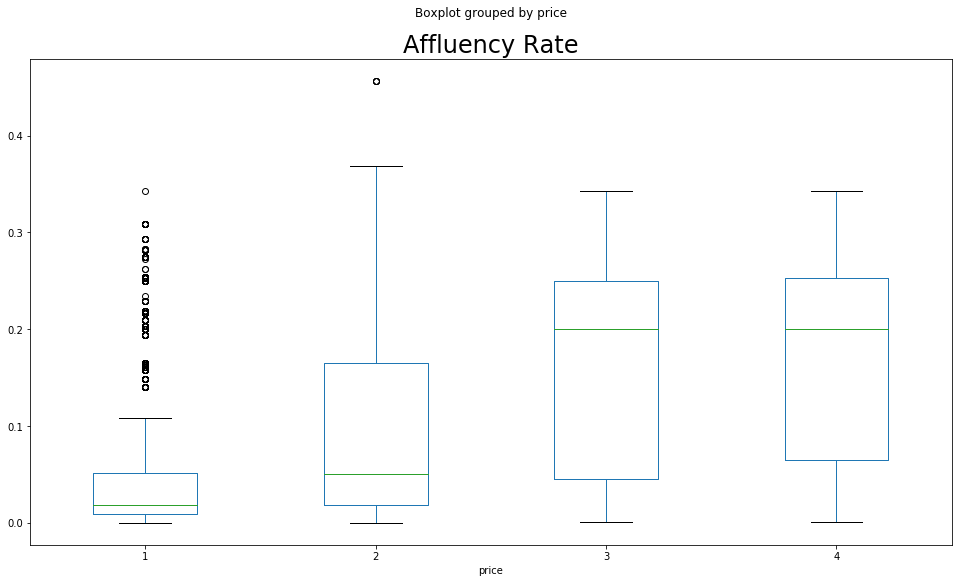

In [187]:
complete_df.boxplot("affluency_rate", by ="price", figsize = (16,9), grid=False)

plt.title('Affluency Rate', fontsize = 24);

## Affluency by lat/long coordinates

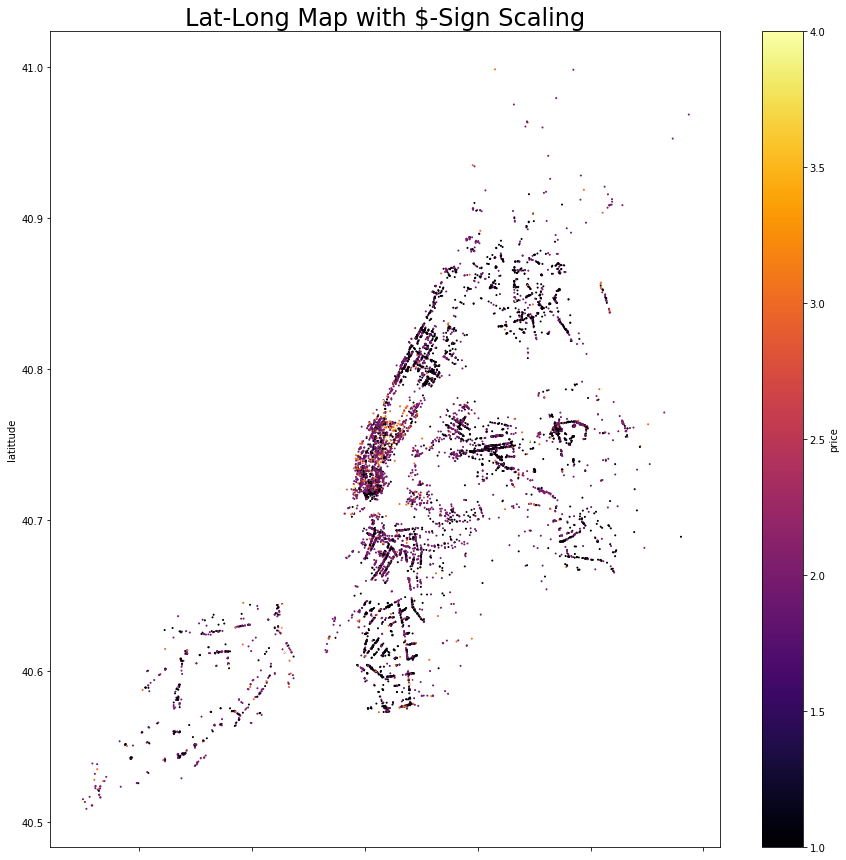

In [191]:
complete_df.plot(kind="scatter", y="latitude", x="longitude", c="price",
         cmap="inferno", figsize=(15, 15), s=1)


plt.title('Lat-Long Map with $-Sign Scaling', fontsize = 24)


plt.ylabel('latitude')
plt.xlabel('Longitutde');

# =============================
# "work in progress"  after this line

In [ ]:
# What do these clusters look like visually?
plt.figure(figsize=(10, 10))
location_data = complete_df[['longitude', 'latitude']]

In [222]:
km.labels_

array([8, 8, 8, ..., 0, 0, 0])

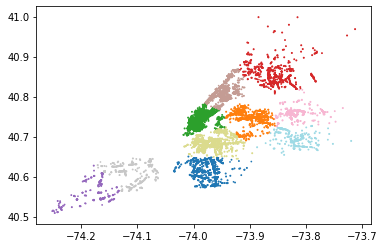

In [200]:
km = KMeans(n_clusters=10)
km.fit(location_data)

silhouette_score(location_data, km.labels_)

plt.scatter(complete_df.longitude, complete_df.latitude, c=km.labels_, s=complete_df['rating']/4, cmap="tab20");

In [133]:
def kscore(data, clusters):
    km = KMeans(n_clusters=clusters, random_state = 42, n_jobs=4)
    km.fit(data)
    return silhouette_score(data, km.labels_)

In [134]:
kscore_list = []

for i in range(30):
    kscore_list.append(kscore(location_data, i+2))

In [135]:
kscore_list

[0.44240113768519956,
 0.46061813986399675,
 0.44163994495369696,
 0.4777121614561612,
 0.4848394681479744,
 0.5108063831559393,
 0.5241318061159189,
 0.517047057895022,
 0.5262445154638148,
 0.5156582913075968,
 0.4946202662625379,
 0.4965228473665534,
 0.48752508514191356,
 0.48163096703811276,
 0.48137303330732467,
 0.48796072396754686,
 0.46686302532290247,
 0.46439888727190526,
 0.46612543597494427,
 0.46675137235472947,
 0.4584960868667416,
 0.4584791369180741,
 0.4542574946395792,
 0.46089688460287825,
 0.4576780906853004,
 0.46435165280162805,
 0.46744960500688293,
 0.46109025579554563,
 0.4610572770410519,
 0.4406403592129947]

In [324]:
# Let's scoop lat/long up in a matrix so we can use them easily
location_data = df_yelp[["latitude", "longitude"]]
location_data.head()

,latitude,longitude
1,40.683370,-73.943780
2,40.685610,-73.980350
3,40.690812,-73.953915
4,40.674210,-73.963240
5,40.686023,-73.991302


In [328]:
# Let's cluster our observations by lat/long
km = KMeans(n_clusters=20)
km.fit(location_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### Top 5 Highest Affluent Area Within NYC
 - Lower Manhattan
 - Westchester County
 - Gramercy Park / Murray Hill	
 - Pelham
 - Upper East Side

#### Top 5 Lowest Affluent Area Within NYC
 - Highbridge
 - Morris Heights
 - Brownsville
 - Belmont
 - Mott Haven

In [221]:
complete_df.groupby('zip_code')['affluency_rate'].mean().sort_values().head()

zip_code
10452    0.000552
10453    0.000798
11212    0.001042
10458    0.001166
10460    0.001194
Name: affluency_rate, dtype: float64

In [211]:
list(complete_df.columns)

['id',
 'price',
 'rating',
 'review_count',
 'zip_code',
 'city',
 'state',
 'latitude',
 'longitude',
 'affluency_rate',
 'categories_steak',
 'categories_headshops',
 'categories_kitchensupplies',
 'categories_giftshops',
 'categories_pakistani',
 'categories_dimsum',
 'categories_skate_parks',
 'categories_drugstores',
 'categories_ethiopian',
 'categories_speakeasies',
 'categories_musicvenues',
 'categories_adultedu',
 'categories_bookstores',
 'categories_hotpot',
 'categories_tuscan',
 'categories_raw_food',
 'categories_cheesesteaks',
 'categories_tradamerican',
 'categories_catering',
 'categories_arabian',
 'categories_eritrean',
 'categories_brazilian',
 'categories_gluten_free',
 'categories_internetcafe',
 'categories_taiwanese',
 'categories_portuguese',
 'categories_restaurants',
 'categories_popuprestaurants',
 'categories_virtualrealitycenters',
 'categories_sports_clubs',
 'categories_danceclubs',
 'categories_intlgrocery',
 'categories_sportsbars',
 'categories_bage

# ======================
# "work in progress" before here

## Model Preparation

** Should we consider city? It's worse than lat/long, which we're already using **

We plan to compose lat/long during feature engineering via clustering to create a new composite features

In [369]:
xfeatures = ["id","city",'latitude','longitude']
X = complete_df.drop(columns=xfeatures)
y = complete_df["is_affluent"]

## Model Selection
- [Hadi] Exploring models
- [Eddie] Exploring models

Maybe split on which models you 2 want to try out

## Model Evaluation
- [Mahdi] killer graphs and visuals

## Conclusions and Recommendations
- [All]

## Source Documentation
- [NYC zip codes](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)
- [Yelp API - Business Endpoints](https://www.yelp.com/fusion)
- [IRS dataset](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi)